## Use Case: For classifiying flowers data set from kaggle.com using clustering technique.

## Data set: https://www.kaggle.com/olgabelitskaya/flower-color-images

## Step 1:  We need to import the modules needed in order to load/process the images along with the modules to extract and cluster our feature vectors.

## > keras, pickle, tensorlow are required.

In [48]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [49]:
pip install pickle

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [2]:
pip install tensorflow

  Using cached tensorflow-2.5.0-cp38-cp38-win_amd64.whl (422.6 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached absl_py-0.13.0-py3-none-any.whl (132 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached numpy-1.19.5-cp38-cp38-win_amd64.whl (13.3 MB)
  Using cached tensorflow_estimator-2.5.0-py2.py3-none-any.whl (462 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached h5py-3.1.0-cp38-cp38-win_amd64.whl (2.7 MB)
  Using cached tensorboard-2.5.0-py3-none-any.whl (6.0 MB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached grpcio-1.34.1-cp38-cp38-win_amd64.whl (2.9 MB)
  Using cached keras_nightly-2.5.0.dev2021032900-py2.py3-none-any.whl (1.2 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached google_auth_oauthlib-0.4.4-py2.py3-none-any.whl (18 kB)
  Usi

In [3]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

In [4]:
# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

In [5]:
# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [6]:
# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

## Step2: Loading the data.

In [7]:
path = r"C:\Users\Admin\Desktop\Data Science Internship May-2021\flower_images\flower_images"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
flowers = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            flowers.append(file.name)

## Step3: Data Preprocessing. Converting the dataset into numpy array.

In [12]:
# load the image as a 224x224 array
img = load_img(flowers[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)

(224, 224, 3)


In [13]:
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)

(1, 224, 224, 3)


In [14]:
x = preprocess_input(reshaped_img)

## Step4: Creating the Model.

In [15]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

## Step5: Creating a user defined function(extract_features) to extract features from all of the images and store the features in a dictionary with filename as the keys.

In [18]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [20]:
data = {}
p = r"C:\Users\Admin\Desktop\Data Science Internship May-2021\Flower_output"

# loop through each image in the dataset
for flower in flowers:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(flower,model)
        data[flower] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)
          
 
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
feat.shape
(210, 1, 4096)

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape
(210, 4096)

# get the unique labels (from the flower_labels.csv)
df = pd.read_csv('flower_labels.csv')
label = df['label'].tolist()
unique_labels = list(set(label))

## Step6: Dimensionality Reduction (PCA).Our feature vector has over 4,000 dimensions, reducing it to a much smaller number.
## >Using principle component analysis.

In [21]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

## Step7: Applying KMeans clustering.

In [22]:
kmeans = KMeans(n_clusters=len(unique_labels),n_jobs=-1, random_state=22)
kmeans.fit(x)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(n_clusters=10, n_jobs=-1, random_state=22)

In [23]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

## Step 8: To Know number of clusters.

In [24]:
print(cluster)

3


## >Prints the clusters divided.

In [37]:
for i in range(3):
    print(groups[i])

['0009.png', '0036.png', '0049.png', '0060.png', '0079.png', '0099.png', '0107.png', '0109.png', '0117.png', '0129.png', '0136.png', '0165.png', '0175.png', '0183.png', '0188.png', '0195.png']
['0004.png', '0005.png', '0008.png', '0010.png', '0018.png', '0040.png', '0058.png', '0065.png', '0085.png', '0119.png', '0120.png', '0137.png', '0207.png']
['0022.png', '0046.png', '0052.png', '0070.png', '0082.png', '0088.png', '0090.png', '0103.png', '0112.png', '0123.png', '0134.png', '0140.png', '0142.png', '0148.png', '0152.png', '0178.png', '0191.png', '0200.png', '0205.png', '0208.png']


In [38]:
groups[0]

['0009.png',
 '0036.png',
 '0049.png',
 '0060.png',
 '0079.png',
 '0099.png',
 '0107.png',
 '0109.png',
 '0117.png',
 '0129.png',
 '0136.png',
 '0165.png',
 '0175.png',
 '0183.png',
 '0188.png',
 '0195.png']

## Step9: Python code for printing the clusters individually.

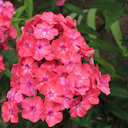

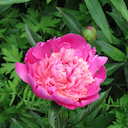

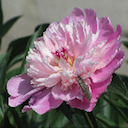

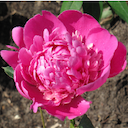

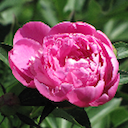

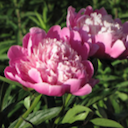

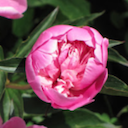

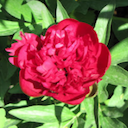

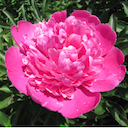

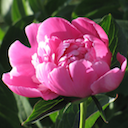

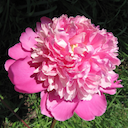

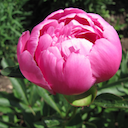

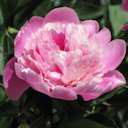

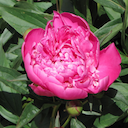

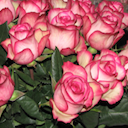

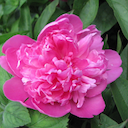

In [43]:
from IPython.display import Image, display
listOfImageNames = groups[0]
for imageName in listOfImageNames:
    display(Image(filename=imageName))

In [44]:
groups[1]

['0004.png',
 '0005.png',
 '0008.png',
 '0010.png',
 '0018.png',
 '0040.png',
 '0058.png',
 '0065.png',
 '0085.png',
 '0119.png',
 '0120.png',
 '0137.png',
 '0207.png']

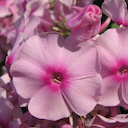

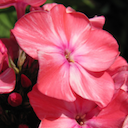

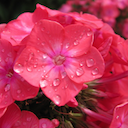

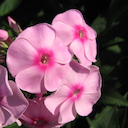

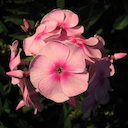

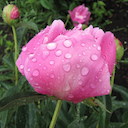

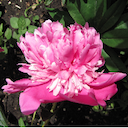

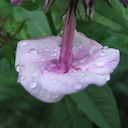

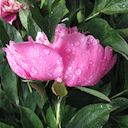

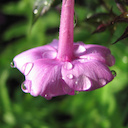

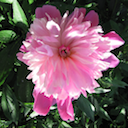

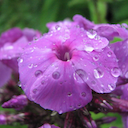

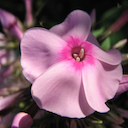

In [45]:
from IPython.display import Image, display
listOfImageNames1 = groups[1]
for imageName in listOfImageNames1:
    display(Image(filename=imageName))

In [46]:
groups[2]

['0022.png',
 '0046.png',
 '0052.png',
 '0070.png',
 '0082.png',
 '0088.png',
 '0090.png',
 '0103.png',
 '0112.png',
 '0123.png',
 '0134.png',
 '0140.png',
 '0142.png',
 '0148.png',
 '0152.png',
 '0178.png',
 '0191.png',
 '0200.png',
 '0205.png',
 '0208.png']

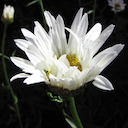

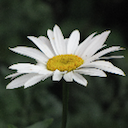

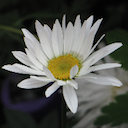

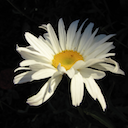

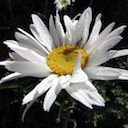

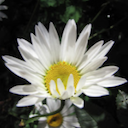

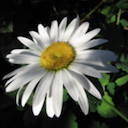

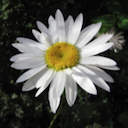

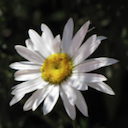

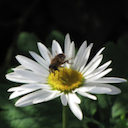

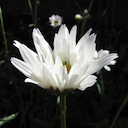

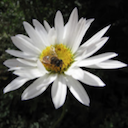

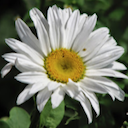

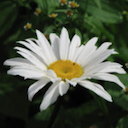

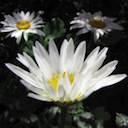

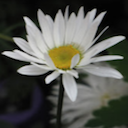

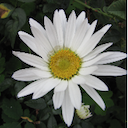

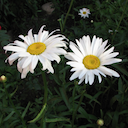

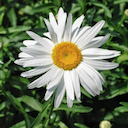

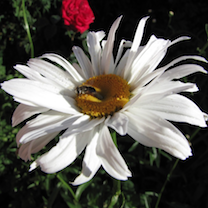

In [47]:
from IPython.display import Image, display
listOfImageNames2 = groups[2]
for imageName in listOfImageNames2:
    display(Image(filename=imageName))

## Result: A real-time database is taken from kaggle.com and performed clustering algorithm on it.